# 연합학습 환경에서의 머신 언러닝 기법

1. 언러닝의 목표가 무엇인가? 
: 서버를 속이는 것인가? 클라이언트를 속이는 것인가? 아니면 외부 공격자를 속이는 것인가

2. 데이터를 생성하는 건 좋은데 이걸 언러닝 목표에 맞게 어떻게 활용할 것인가?
: retrain 했을 때와 비슷한 성능을 지니면서, 시간적으로 효율적이고, 다른 언러닝 기법과 비교했을 때 성능이 보장되어야함

3. 항상 default 값으로 같이 비교할 수치
: original 모델(언러닝을 진행하지 않은 연합학습 모델), retrain 모델(언러닝 요청이 들어와 언러닝 클라이언트를 제외하고 나머지 클라이언트만 다시 학습), fine-tune 모델 (데이터 생성을 통한 언러닝 적용)  

In [ ]:
import os
import time
import copy
import json
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn

import matplotlib.pyplot as plt     
import torchvision.utils as vutils 

from torch.utils.data import DataLoader, ConcatDataset, Subset #unseen data를 통해서 언러닝 재학습에서 사용.
from torch.utils.data import TensorDataset

from options import args_parser
from update import LocalUpdate, test_inference
from models import CNNMnist,ResNet18, CNNCifar, Generator, Discriminator, generate_images, filter_images
from utils import get_dataset, average_weights, exp_details, create_poisoned_dataset, generate_fixed_threshold_data
from unlearn import (
    train_generator_ungan,
    train_gd_ungan,
    train_gd_ungan_with_unseen,
    train_gd_ungan_unseen_only, 
    train_gd_ungan_forget_only,
    SyntheticImageDataset, 
    partition_synthetic_data_iid,
    partition_synthetic_data_dirichlet,
    get_synthetic_subset
)
from evaluate_mia import evaluate_mia, comprehensive_evaluation, evaluate_synthetic_classification_accuracy, evaluate_classification_accuracy

In [2]:
def visualize_real_vs_generated_with_filtering(generator, discriminator, dataset, forget_idxs, 
                                             z_dim=100, device='cpu', threshold=0.5, num_samples=16):
    """
    실제 이미지, 생성된 이미지, 필터링된 이미지를 모두 비교 시각화
    """
    # 실제 이미지 샘플링
    real_images = []
    sample_idxs = np.random.choice(forget_idxs, min(num_samples, len(forget_idxs)), replace=False)
    
    for idx in sample_idxs:
        img, _ = dataset[idx]
        real_images.append(img)
    
    real_images = torch.stack(real_images)
    
    # 더 많은 이미지를 생성해서 필터링 효과를 보여주기
    num_generate = num_samples * 2  # 2배 생성해서 필터링
    
    # 생성된 이미지
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        # 기존: noise = torch.randn(num_generate, z_dim, device=device)
        # 수정: DCGAN 형식으로 (batch, z_dim, 1, 1)
        noise = torch.randn(num_generate, z_dim, 1, 1, device=device)
        
        generated_images = generator(noise)
        
        # Discriminator로 품질 평가
        d_scores = discriminator(generated_images.to(device))
        
        # CPU로 이동하고 정규화
        generated_images = generated_images.cpu()
        generated_images = torch.clamp(generated_images, -1, 1)
        generated_images = (generated_images + 1) / 2
        
        # 필터링 (threshold 이상만 선택)
        d_scores = d_scores.cpu().squeeze()
        high_quality_mask = d_scores > threshold
        
        if high_quality_mask.sum() > 0:
            filtered_images = generated_images[high_quality_mask]
            filtered_scores = d_scores[high_quality_mask]
            # 상위 num_samples개만 선택
            if len(filtered_images) > num_samples:
                top_indices = torch.topk(filtered_scores, num_samples)[1]
                filtered_images = filtered_images[top_indices]
        else:
            # 필터링된 이미지가 없으면 상위 점수 이미지들 선택
            top_indices = torch.topk(d_scores, num_samples)[1]
            filtered_images = generated_images[top_indices]
    
    # 실제 이미지 정규화
    if real_images.min() < 0:  # 이미 정규화된 경우
        real_images = (real_images + 1) / 2
    elif real_images.max() > 1:  # 0-255 범위
        real_images = real_images / 255.0
    
    # 3행으로 비교 시각화
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 9))
    
    # 실제 이미지
    real_grid = vutils.make_grid(real_images, nrow=8, normalize=False, padding=2)
    real_grid_np = real_grid.permute(1, 2, 0).numpy()
    ax1.imshow(real_grid_np, cmap='gray' if real_images.shape[1] == 1 else None)
    ax1.set_title('Real Images (Forget Set)', fontsize=14)
    ax1.axis('off')
    
    # 모든 생성된 이미지 (처음 num_samples개)
    all_gen_grid = vutils.make_grid(generated_images[:num_samples], nrow=8, normalize=False, padding=2)
    all_gen_grid_np = all_gen_grid.permute(1, 2, 0).numpy()
    ax2.imshow(all_gen_grid_np, cmap='gray' if generated_images.shape[1] == 1 else None)
    ax2.set_title('All Generated Images', fontsize=14)
    ax2.axis('off')
    
    # 필터링된 고품질 이미지
    filtered_grid = vutils.make_grid(filtered_images, nrow=8, normalize=False, padding=2)
    filtered_grid_np = filtered_grid.permute(1, 2, 0).numpy()
    ax3.imshow(filtered_grid_np, cmap='gray' if filtered_images.shape[1] == 1 else None)
    ax3.set_title(f'High-Quality Filtered Images (D-score > {threshold})', fontsize=14)
    ax3.axis('off')
    
    plt.tight_layout()
    plt.savefig('./real_vs_generated_filtered.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Discriminator 점수 통계 출력
    print(f"Discriminator Scores - Mean: {d_scores.mean():.3f}, Std: {d_scores.std():.3f}")
    print(f"High-quality images (>{threshold}): {high_quality_mask.sum().item()}/{len(d_scores)}")
    print("Comparison image saved to: ./real_vs_generated_filtered.png")


# visualize_discriminator_scores 함수도 동일하게 수정
def visualize_discriminator_scores(generator, discriminator, z_dim=100, device='cpu', num_samples=100):
    """
    Discriminator 점수 분포를 히스토그램으로 시각화
    """
    generator.eval()
    discriminator.eval()
    
    with torch.no_grad():
        # ========== 여기도 수정! ==========
        # 기존: noise = torch.randn(num_samples, z_dim, device=device)
        # 수정: DCGAN 형식으로
        noise = torch.randn(num_samples, z_dim, 1, 1, device=device)
        
        generated_images = generator(noise)
        d_scores = discriminator(generated_images).cpu().squeeze().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.hist(d_scores, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Discriminator Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Discriminator Scores for Generated Images')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('./discriminator_scores_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Discriminator scores - Min: {d_scores.min():.3f}, Max: {d_scores.max():.3f}")
    print(f"Mean: {d_scores.mean():.3f}, Std: {d_scores.std():.3f}")
    print("Discriminator scores distribution saved to: ./discriminator_scores_distribution.png")

In [3]:
def move_dataset_to_device(dataset, device):
    images = []
    labels = []
    for x, y in dataset:
        images.append(x.to(device))
        labels.append(torch.tensor(y).to(device))
    return TensorDataset(torch.stack(images), torch.stack(labels))


def add_backdoor_trigger(x):
    x_bd = x.clone()
    x_bd[:, 25:28, 25:28] = 0.9
    return x_bd

def evaluate_backdoor_asr(model, dataset, target_label, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i in range(len(dataset)):
            x, y = dataset[i]
            # 백도어 트리거 삽입
            x_bd = add_backdoor_trigger(x).to(device)
            x_bd = x_bd.unsqueeze(0)  # 배치 차원 추가

            output = model(x_bd)
            pred = output.argmax(dim=1).item()

            total += 1
            if pred == target_label:
                correct += 1

    asr = correct / total
    return asr

def select_model(args, train_dataset):
    if args.model == 'cnn':
        if args.dataset == 'cifar':
            return CNNCifar(args=args)  # CIFAR-10용 CNN 추가 필요
        else:
            return CNNMnist(args=args)  # MNIST용 CNN
    elif args.model == 'resnet':
        return ResNet18(num_classes=args.num_classes)  # CIFAR-10용 ResNet
    else:
        raise NotImplementedError


In [4]:
# def main():
#     start_time = time.time()
#     args = args_parser()
#     device = 'cuda' if args.gpu and torch.cuda.is_available() else 'cpu'

#     exp_details(args)

#     # ===================== 1. 데이터셋 로딩 및 초기화 =====================
#     train_dataset, test_dataset, unseen_dataset, user_groups = get_dataset(args)
#     # full_dataset, user_groups = create_poisoned_dataset(train_dataset, user_groups, args,
#     #                                                     malicious_client=0,
#     #                                                     target_label=6,
#     #                                                     poison_ratio=0.8)
#     full_dataset = train_dataset  # create_poisoned_dataset 제거

#     global_model = select_model(args, full_dataset).to(device)
#     global_model.train()

#     if args.dataset == 'cifar':
#         generator = Generator(z_dim=args.z_dim, img_shape=(3, 32, 32)).to(device)      
#         discriminator = Discriminator(img_shape=(3, 32, 32)).to(device)                
#     else:
#         generator = Generator(z_dim=args.z_dim).to(device)
#         discriminator = Discriminator().to(device)


#     # DCGAN 가중치 초기화 적용
#     from models import weights_init
#     generator.apply(weights_init)
#     discriminator.apply(weights_init)

#     global_weights = global_model.state_dict()
#     train_loss, train_accuracy = [], []

#     forget_client = 0
#     forget_idxs = user_groups[forget_client]
#     retain_idxs = [i for i in range(len(train_dataset)) if i not in forget_idxs]
#     test_idxs = np.random.choice(len(test_dataset), len(forget_idxs), replace=False)

#     # 데이터 수량 균형 - unseen 데이터 준비
#     forget_size = len(forget_idxs)
#     unseen_idxs = np.random.choice(len(unseen_dataset), forget_size, replace=False)
#     unseen_subset = Subset(unseen_dataset, unseen_idxs)
    
#     print(f"Data sizes - Forget: {forget_size}, Unseen: {len(unseen_idxs)}")


#     # ===================== 2. 연합 학습 (FedAvg) =====================
#     fedavg_start_time = time.time()

#     for epoch in tqdm(range(args.epochs), desc='Global Training Rounds'):
#         print(f'\n| Global Training Round : {epoch + 1} |')

#         local_weights, local_losses = [], []
#         m = max(int(args.frac * args.num_users), 1)
#         idxs_users = np.random.choice(range(args.num_users), m, replace=False)

#         for idx in idxs_users:
#             # if idx == forget_client:
#             #     continue  # 언러닝 요청자 제거 / 재학습
#             local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
#             w, loss = local_model.update_weights(model=copy.deepcopy(global_model), global_round=epoch)
#             local_weights.append(copy.deepcopy(w))
#             local_losses.append(loss)

#         global_weights = average_weights(local_weights)
#         global_model.load_state_dict(global_weights)
        
#         loss_avg = sum(local_losses) / len(local_losses)
#         acc, _ = test_inference(args, global_model, test_dataset)
#         train_loss.append(loss_avg)
#         train_accuracy.append(acc)

#         print(f"Training Loss: {loss_avg:.4f} | Train Accuracy: {acc*100:.2f}%")

#     fedavg_time = time.time() - fedavg_start_time
#     original_model = copy.deepcopy(global_model)
    
     
#     # ===================== 3. MIA 평가 (언러닝 전) =====================
#     print("[MIA] Evaluating membership inference attack...")

#     all_idxs = set(range(len(full_dataset)))
#     non_member_candidates = list(all_idxs - set(forget_idxs))
#     #여기에서 쉐도우에는 forget 데이터가 없도록 하기.
#     mia_result_before = evaluate_mia(
#         model=global_model,
#         dataset=full_dataset,
#         test_dataset= test_dataset,
#         forget_idxs=forget_idxs,
#         retain_idxs=test_idxs,
#         shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
#         device=device,
#         save_path="./mia_result_before.json"
#     )

#     # ===================== 4. 합성 데이터 생성 및 시각화 =====================
#     print("\n[Generating synthetic data with Forget + Unseen training...]")

#     unlearning_start_time = time.time()

#     # train_gd_ungan 대신 train_gd_ungan_with_unseen 사용
#     generator, discriminator = train_gd_ungan_with_unseen(
#         generator=generator,
#         discriminator=discriminator,
#         dataset=full_dataset,
#         retain_idxs=retain_idxs,
#         forget_idxs=forget_idxs,
#         device=device,
#         lambda_adv=1.0,  # unseen similarity loss 가중치
#         z_dim=args.z_dim,
#         batch_size=64,
#         epochs=500,
#         unseen_dataset=unseen_dataset  # unseen_dataset 추가
#     )

#     # 고정 임계값으로 forget_size만큼 생성
#     synthetic_images, synthetic_labels = generate_fixed_threshold_data(
#         generator=generator,
#         discriminator=discriminator,
#         forget_idxs=forget_idxs,
#         dataset=full_dataset,
#         device=device,
#         z_dim=args.z_dim,
#         target_count=forget_size,
#         fixed_threshold=args.gen_threshold,
#         batch_size=64
#     )

#     synthetic_dataset = SyntheticImageDataset(synthetic_images, synthetic_labels)
    
#     print("[Visualizing real vs synthetic images...]")
#     visualize_real_vs_generated_with_filtering(
#         generator, discriminator, full_dataset, forget_idxs, 
#         args.z_dim, device, args.gen_threshold
#     )

#     unlearning_time = time.time() - unlearning_start_time

#     # ===================== 5. 언러닝 후 성능 평가 ===================== 
#     print("\n========== After Unlearning - Model Performance Evaluation ===========")
    
#     # Retrain Model (Retain 데이터만으로 연합학습 재훈련)
#     retrain_start_time = time.time()
#     retrain_model = select_model(args, full_dataset).to(device)
    
#     # forget_client를 제외한 연합학습으로 재훈련
#     for epoch in tqdm(range(args.epochs), desc='Retrain Federated Training'):
#         print(f'\n| Retrain Training Round : {epoch + 1} |')

#         local_weights, local_losses = [], []
#         m = max(int(args.frac * args.num_users), 1)
#         idxs_users = np.random.choice(range(args.num_users), m, replace=False)
        
#         # forget_client 제외
#         idxs_users = [idx for idx in idxs_users if idx != forget_client]

#         for idx in idxs_users:
#             local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
#             w, loss = local_model.update_weights(model=copy.deepcopy(retrain_model), global_round=epoch)
#             local_weights.append(copy.deepcopy(w))
#             local_losses.append(loss)

#         global_weights = average_weights(local_weights)
#         retrain_model.load_state_dict(global_weights)
        
#         loss_avg = sum(local_losses) / len(local_losses)
#         print(f"Retrain Training Loss: {loss_avg:.4f}")

#     retrain_time = time.time() - retrain_start_time
    

#     # Fine-tune Model (합성 데이터 + retain 데이터로 연합학습)
#     finetune_start_time = time.time()
#     finetune_model = copy.deepcopy(original_model)
    
#     # forget_client를 제외한 연합학습 진행
#     for epoch in tqdm(range(args.epochs), desc='Finetune Federated Training'):
#         print(f'\n| Finetune Training Round : {epoch + 1} |')

#         local_weights, local_losses = [], []
#         m = max(int(args.frac * args.num_users), 1)
#         idxs_users = np.random.choice(range(args.num_users), m, replace=False)
        
#         # forget_client 제외
#         idxs_users = [idx for idx in idxs_users if idx != forget_client]

#         for idx in idxs_users:
#             local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
#             w, loss = local_model.update_weights(model=copy.deepcopy(finetune_model), global_round=epoch)
#             local_weights.append(copy.deepcopy(w))
#             local_losses.append(loss)
        
#         # 합성 데이터로 추가 학습
#         synthetic_local_model = LocalUpdate(args=args, dataset=synthetic_dataset, idxs=list(range(len(synthetic_dataset))))
#         w_synthetic, loss_synthetic = synthetic_local_model.update_weights(model=copy.deepcopy(finetune_model), global_round=epoch)
#         local_weights.append(copy.deepcopy(w_synthetic))
#         local_losses.append(loss_synthetic)

#         global_weights = average_weights(local_weights)
#         finetune_model.load_state_dict(global_weights)
        
#         loss_avg = sum(local_losses) / len(local_losses)
#         print(f"Finetune Training Loss: {loss_avg:.4f}")

#     finetune_time = time.time() - finetune_start_time

    
#     # ===================== 6. MIA 평가 (언러닝 후) =====================
#     print("[MIA] Evaluating membership inference attack after unlearning...")

#     # Retrain Model MIA 평가
#     mia_retrain_after = evaluate_mia(
#         model=retrain_model,
#         dataset=full_dataset,
#         test_dataset=test_dataset,
#         forget_idxs=forget_idxs,
#         retain_idxs=test_idxs,
#         shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
#         device=device,
#         save_path="./mia_result_retrain.json"
#     )
    
#     # Fine-tune Model MIA 평가
#     mia_finetune_after = evaluate_mia(
#         model=finetune_model,
#         dataset=full_dataset,
#         test_dataset=test_dataset,
#         forget_idxs=forget_idxs,
#         retain_idxs=test_idxs,
#         shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
#         device=device,
#         save_path="./mia_result_finetune.json"
#     )


#     # ===================== 7. 최종 성능 측정 =====================
#     original_acc_before, original_loss_before = test_inference(args, original_model, test_dataset)
#     retrain_acc_after, retrain_loss_after = test_inference(args, retrain_model, test_dataset)
#     finetune_acc_after, finetune_loss_after = test_inference(args, finetune_model, test_dataset)
    
#     end_time = time.time()
#     elapsed_time = end_time - start_time


#     # ===================== 8. FINAL RESULT SUMMARY =====================
#     print("\n" + "="*80)
#     print("                       FINAL RESULT SUMMARY")
#     print("="*80)
    
#     print(f"\nDataset Information:")
#     print(f"  Total Training Data: {len(full_dataset):,}")
#     print(f"  Forget Set Size: {len(forget_idxs):,}")
#     print(f"  Retain Set Size: {len(retain_idxs):,}")
#     print(f"  Test Set Size: {len(test_dataset):,}")
#     print(f"  Generated Synthetic Data: {len(synthetic_images):,}")
    
#     print(f"\nTraining Time Analysis:")
#     print(f"  Federated Learning (with unlearning at epoch {unlearning_request_epoch + 1}): {fedavg_time:.2f} seconds")
#     print(f"  Unlearning Process (Data Generation): {unlearning_time:.2f} seconds")
#     print(f"  Retrain Time : {retrain_time:.2f} seconds")
#     print(f"  Finetune Time : {finetune_time:.2f} seconds")
#     print(f"  Total Execution Time: {elapsed_time:.2f} seconds")

#     print(f"\nModel Performance Comparison:")
#     print(f"  Original Model: {original_acc_before*100:6.2f}% (Loss: {original_loss_before:.4f})")
#     print(f"  Retrain Model: {retrain_acc_after*100:6.2f}% (Loss: {retrain_loss_after:.4f})")
#     print(f"  Fine-tune Model (Ours): {finetune_acc_after*100:6.2f}% (Loss: {finetune_loss_after:.4f})")

#     print(f"\nPrivacy Analysis (MIA AUC):")
#     print(f"  Before Unlearning: {mia_result_before['auc']:.4f}")
#     print(f"  After Unlearning: {mia_finetune_after['auc']:.4f}    |    {mia_retrain_after['auc']:.4f}")
    
    

#     #torch.save(global_model.state_dict(), args.save_model)
#     #print(f"[Saved] model to {args.save_model}\n")

In [ ]:
def main():
    start_time = time.time()
    args = args_parser()
    device = 'cuda' if args.gpu and torch.cuda.is_available() else 'cpu'

    exp_details(args)

    # ===================== 1. 데이터셋 로딩 및 초기화 =====================
    train_dataset, test_dataset, unseen_dataset, user_groups = get_dataset(args)
    full_dataset = train_dataset  

    global_model = select_model(args, full_dataset).to(device)
    global_model.train()

    if args.dataset == 'cifar':
        generator = Generator(z_dim=args.z_dim, img_shape=(3, 32, 32)).to(device)      
        discriminator = Discriminator(img_shape=(3, 32, 32)).to(device)                
    else:
        generator = Generator(z_dim=args.z_dim).to(device)
        discriminator = Discriminator().to(device)

    # DCGAN 가중치 초기화 적용
    from models import weights_init
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    global_weights = global_model.state_dict()
    train_loss, train_accuracy = [], []

    forget_client = 0
    forget_idxs = user_groups[forget_client]
    retain_idxs = [i for i in range(len(train_dataset)) if i not in forget_idxs]
    test_idxs = np.random.choice(len(test_dataset), len(forget_idxs), replace=False)

    # 데이터 수량 균형 - unseen 데이터 준비
    forget_size = len(forget_idxs)
    unseen_idxs = np.random.choice(len(unseen_dataset), forget_size, replace=False)
    unseen_subset = Subset(unseen_dataset, unseen_idxs)
    
    # 데이터 분배 정보 출력 
    print("\n" + "="*70)
    print("DATASET DISTRIBUTION".center(70))
    print("="*70)
    print(f"Total Training Data: {len(full_dataset):,}")
    print(f"Test Data: {len(test_dataset):,}")
    print(f"Unseen Data Pool: {len(unseen_dataset):,}")
    print(f"\nFederated Learning Setup:")
    print(f"   Forget Set Size: {len(forget_idxs):,}")
    print(f"   Retain Set Size: {len(retain_idxs):,}")
    print(f"   Unseen Used for Generating: {len(unseen_idxs):,}")
    print("="*70)

    # ===================== 2. Original 연합학습 (언러닝 요청 무시) =====================
    print("\n" + "="*70)
    print("ORIGINAL FEDERATED LEARNING".center(70))
    print("="*70)

    fedavg_start_time = time.time()
    unlearning_request_epoch = args.epochs // 2  # 중간 지점에서 언러닝 요청
    unlearning_requested = False
    unlearning_epoch_model = None  # 언러닝 요청 시점의 모델 저장

    for epoch in tqdm(range(args.epochs), desc='Original FL Training'):
        if epoch == unlearning_request_epoch and not unlearning_requested:
            print("\n" + "="*70)
            print(f"UNLEARNING REQUEST - CLIENT {forget_client} AT EPOCH {epoch + 1}".center(70))
            print("="*70)

            unlearning_requested = True
            unlearning_epoch_model = copy.deepcopy(global_model)  # 언러닝 요청 시점 모델 저장
            print("\n[NOTE] Original model continues training with all clients (ignoring unlearning request)")

        local_weights, local_losses = [], []
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)

        # Original 모델은 언러닝 요청을 무시하고 모든 클라이언트와 계속 학습
        for idx in idxs_users:
            local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
            w, loss = local_model.update_weights(model=copy.deepcopy(global_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w))
            local_losses.append(loss)

        global_weights = average_weights(local_weights)
        global_model.load_state_dict(global_weights)
        
        loss_avg = sum(local_losses) / len(local_losses)
        acc, _ = test_inference(args, global_model, test_dataset)
        train_loss.append(loss_avg)
        train_accuracy.append(acc)

        if (epoch + 1) % 5 == 0:
            print(f"[Original] Epoch {epoch+1}/{args.epochs} | Loss: {loss_avg:.4f} | Acc: {acc*100:.2f}%")

    fedavg_time = time.time() - fedavg_start_time
    original_model = copy.deepcopy(global_model)

    # ===================== 3. 합성 데이터 생성 및 시각화 =====================
    print("\n" + "="*70)
    print("SYNTHETIC DATA GENERATION WITH GAN".center(70))
    print("="*70)
    generation_start_time = time.time()
    
    # train_gd_ungan 대신 train_gd_ungan_with_unseen 사용
    generator, discriminator = train_gd_ungan_with_unseen(
        generator=generator,
        discriminator=discriminator,
        dataset=full_dataset,
        retain_idxs=retain_idxs,
        forget_idxs=forget_idxs,
        device=device,
        lambda_adv=1.0,  # unseen similarity loss 가중치
        z_dim=args.z_dim,
        batch_size=64,
        epochs=500,
        unseen_dataset=unseen_dataset  # unseen_dataset 추가
    )

    # generator, discriminator = train_gd_ungan_unseen_only(
    #     generator=generator,
    #     discriminator=discriminator,
    #     dataset=full_dataset,
    #     retain_idxs=retain_idxs,
    #     forget_idxs=forget_idxs,
    #     device=device,
    #     lambda_adv=1.0,
    #     z_dim=args.z_dim,
    #     batch_size=64,
    #     epochs=500,
    #     unseen_dataset=unseen_dataset
    # )

    # 옵션 3: Forget 데이터만 사용
    # generator, discriminator = train_gd_ungan_forget_only(
    #     generator=generator,
    #     discriminator=discriminator,
    #     dataset=full_dataset,
    #     retain_idxs=retain_idxs,
    #     forget_idxs=forget_idxs,
    #     device=device,
    #     lambda_adv=1.0,
    #     z_dim=args.z_dim,
    #     batch_size=64,
    #     epochs=500,
    #     unseen_dataset=unseen_dataset
    # )

    # 고정 임계값으로 forget_size만큼 생성
    synthetic_images, synthetic_labels = generate_fixed_threshold_data(
        generator=generator,
        discriminator=discriminator,
        forget_idxs=forget_idxs,
        dataset=full_dataset,
        device=device,
        z_dim=args.z_dim,
        target_count=forget_size,
        fixed_threshold=args.gen_threshold,
        batch_size=64
    )

    synthetic_dataset = SyntheticImageDataset(synthetic_images, synthetic_labels)
    
    print("\n" + "="*70)
    print("VISUALIZING REAL VS SYNTHETIC IMAGES".center(70))
    print("="*70)
    visualize_real_vs_generated_with_filtering(
        generator, discriminator, full_dataset, forget_idxs, 
        args.z_dim, device, args.gen_threshold
    )

    generation_time = time.time() - generation_start_time
    print(f"Generated {len(synthetic_images):,} synthetic images in {generation_time:.2f}s")

    # ===================== 4. Retrain 모델 (완전 재학습) =====================
    print("\n" + "="*70)
    print("RETRAIN MODEL".center(70))
    print("="*70)
    retrain_start_time = time.time()
    retrain_model = select_model(args, full_dataset).to(device)
    
    # forget_client를 제외한 연합학습으로 재훈련
    for epoch in tqdm(range(args.epochs), desc='Retrain FL Training'):
        local_weights, local_losses = [], []
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)
        
        # forget_client 제외
        idxs_users = [idx for idx in idxs_users if idx != forget_client]

        for idx in idxs_users:
            local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
            w, loss = local_model.update_weights(model=copy.deepcopy(retrain_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w))
            local_losses.append(loss)

        if local_weights:  # 빈 리스트 체크
            global_weights = average_weights(local_weights)
            retrain_model.load_state_dict(global_weights)
            
            loss_avg = sum(local_losses) / len(local_losses)
            if (epoch + 1) % 5 == 0:
                print(f"[Retrain] Epoch {epoch+1}/{args.epochs} | Loss: {loss_avg:.4f}")

    retrain_time = time.time() - retrain_start_time
    retrain_acc_after, retrain_loss_after = test_inference(args, retrain_model, test_dataset)

    # ===================== 5. Finetune 모델 (합성 데이터로 성능 복구) =====================
    print("\n" + "="*70)
    print("FINETUNE MODEL".center(70))
    print("="*70)

    finetune_start_time = time.time()
    finetune_model = copy.deepcopy(original_model)
    
    # 언러닝 요청 이후 에폭만큼 fine-tuning
    remaining_epochs = args.epochs - unlearning_request_epoch
    
    for epoch in tqdm(range(remaining_epochs), desc='Finetune FL Training'):
        local_weights, local_losses = [], []
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)
        
        # forget_client 제외
        idxs_users = [idx for idx in idxs_users if idx != forget_client]

        for idx in idxs_users:
            local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
            w, loss = local_model.update_weights(model=copy.deepcopy(finetune_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w))
            local_losses.append(loss)
        
        # 합성 데이터로 추가 학습
        if len(synthetic_dataset) > 0:
            synthetic_local_model = LocalUpdate(args=args, dataset=synthetic_dataset, idxs=list(range(len(synthetic_dataset))))
            w_synthetic, loss_synthetic = synthetic_local_model.update_weights(model=copy.deepcopy(finetune_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w_synthetic))
            local_losses.append(loss_synthetic)

        if local_weights:  # 빈 리스트 체크
            global_weights = average_weights(local_weights)
            finetune_model.load_state_dict(global_weights)
            
            loss_avg = sum(local_losses) / len(local_losses)
            if (epoch + 1) % 3 == 0:
                print(f"[Finetune] Epoch {epoch+1}/{remaining_epochs} | Loss: {loss_avg:.4f}")

    finetune_training_time = time.time() - finetune_start_time
    # 올바른 언러닝 시간 계산: 생성 + fine-tuning만 포함
    total_unlearning_time = generation_time + finetune_training_time
    finetune_acc_after, finetune_loss_after = test_inference(args, finetune_model, test_dataset)

    # ===================== 6. MIA 평가 =====================
    print("\n" + "="*70)
    print("MEMBERSHIP INFERENCE ATTACK EVALUATION".center(70))
    print("="*70)

    all_idxs = set(range(len(full_dataset)))
    non_member_candidates = list(all_idxs - set(forget_idxs))
    
    # Original Model MIA 평가
    print(f"\n[MIA] Original Model (Before Unlearning):")
    mia_result_before = evaluate_mia(
        model=original_model,
        dataset=full_dataset,
        test_dataset=test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=test_idxs,
        shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
        device=device,
        save_path="./mia_result_before.json"
    )
    
    # Retrain Model MIA 평가
    print(f"\n[MIA] Retrain Model (Gold Standard):")
    mia_retrain_after = evaluate_mia(
        model=retrain_model,
        dataset=full_dataset,
        test_dataset=test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=test_idxs,
        shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
        device=device,
        save_path="./mia_result_retrain.json"
    )
    
    # Fine-tune Model MIA 평가
    print(f"\n[MIA] Finetune Model (Our Method):")
    mia_finetune_after = evaluate_mia(
        model=finetune_model,
        dataset=full_dataset,
        test_dataset=test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=test_idxs,
        shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
        device=device,
        save_path="./mia_result_finetune.json"
    )

    # ===================== 7. 최종 성능 측정 =====================
    original_acc_before, original_loss_before = test_inference(args, original_model, test_dataset)
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    # ===================== 8. FINAL RESULT SUMMARY =====================
    print("\n" + "="*70)
    print("FINAL RESULT SUMMARY".center(70))
    print("="*70)
    
    print(f"\nDataset Summary:")
    print(f"   Total Training Data: {len(full_dataset):,}")
    print(f"   Forget Set Size: {len(forget_idxs):,}")
    print(f"   Retain Set Size: {len(retain_idxs):,}")
    print(f"   Test Set Size: {len(test_dataset):,}")
    print(f"   Unseen Data Pool: {len(unseen_dataset):,}")
    print(f"   Generated Synthetic Data: {len(synthetic_images):,}")
    
    print(f"\nTraining Time Analysis:")
    print(f"   Original FL:        {fedavg_time:8.2f}s")
    print(f"   Retrain FL:         {retrain_time:8.2f}s")
    print(f"   Unlearning Process: {total_unlearning_time:8.2f}s")
    print(f"     └── Synthetic Generation: {generation_time:8.2f}s") 
    print(f"     └── Finetune Training:    {finetune_training_time:8.2f}s")
    
    
    print(f"\nModel Performance Comparison:")
    print(f"   Original (No Unlearning):  {original_acc_before*100:6.2f}% (Loss: {original_loss_before:.4f})")
    print(f"   Retrain (Ideal Unlearning):   {retrain_acc_after*100:6.2f}% (Loss: {retrain_loss_after:.4f})")
    print(f"   Finetune (Our Method):     {finetune_acc_after*100:6.2f}% (Loss: {finetune_loss_after:.4f})")
    
    print("="*70)
    print("EXPERIMENT COMPLETED SUCCESSFULLY!".center(70))
    print("="*70)

    return {
        'original_acc': original_acc_before, 'retrain_acc': retrain_acc_after, 'finetune_acc': finetune_acc_after,
        'original_time': fedavg_time, 'retrain_time': retrain_time, 'unlearning_time': total_unlearning_time,
        'generation_time': generation_time, 'finetune_training_time': finetune_training_time, 
        'synthetic_count': len(synthetic_images),
        'mia_scores': {'original': mia_result_before['auc'], 'retrain': mia_retrain_after['auc'], 'finetune': mia_finetune_after['auc']}
    }

# 1. Original Model

모든 에포크, 모든 클라이언트와 학습. 언러닝 요청 무시

# 2. Retrain Model 

완전히 새로운 모델로 시작. 처음부터 전체 에포크 동안 forget_client 없이 학습. 이상적인 완전 언러닝의 결과

# 3. Finetune Model (Our Method)

언러닝 요청 시점의 모델부터 시작. 나머지 에포크 동안 합성 데이터로 복구. 실용적인 언러닝 방법

In [6]:
import sys

sys.argv = [
    'ipykernel_launcher.py',
    '--epochs', '20',
    '--num_users', '10',
    '--frac', '1.0',
    '--local_ep', '10',
    '--local_bs', '64',
    '--lr', '0.01',
    '--momentum', '0.9',
    '--dataset', 'cifar',
    '--model', 'resnet',
    '--iid', '0',
    '--gpu', '0',
    '--num_classes', '10',
    '--dirichlet', '1',
    '--alpha', '0.3',
    '--load_model', 'None',
    '--save_model', './saved_models/model.pth',
    '--z_dim', '100',
    '--gen_threshold', '0.2',
    '--num_gen_samples', '128',
]


                       EXPERIMENT SETTINGS
Model           : resnet
Dataset         : cifar
Num Clients     : 10
Fraction        : 1.0
IID             : 0
dirichlet alpha : 0.3
Epoch           : 20
Local Epochs    : 10
Batch Size      : 64
Learning Rate   : 0.01
Generator z_dim : 100
Disc. Threshold : 0.2

                         DATASET DISTRIBUTION                         
Total Training Data: 45,000
Test Data: 10,000
Unseen Data Pool: 5,000

Federated Learning Setup:
   Forget Set Size: 1,739
   Retain Set Size: 43,261
   Unseen Used for Generating: 1,739

                     ORIGINAL FEDERATED LEARNING                      


Original FL Training:  25%|██▌       | 5/20 [16:56<50:46, 203.12s/it]  

[Original] Epoch 5/20 | Loss: 0.1092 | Acc: 65.70%


Original FL Training:  50%|█████     | 10/20 [33:53<33:52, 203.28s/it]

[Original] Epoch 10/20 | Loss: 0.0496 | Acc: 75.18%

              UNLEARNING REQUEST - CLIENT 0 AT EPOCH 11               

[NOTE] Original model continues training with all clients (ignoring unlearning request)


Original FL Training:  75%|███████▌  | 15/20 [50:46<16:54, 202.88s/it]

[Original] Epoch 15/20 | Loss: 0.0173 | Acc: 77.15%


Original FL Training: 100%|██████████| 20/20 [1:07:36<00:00, 202.84s/it]

[Original] Epoch 20/20 | Loss: 0.0081 | Acc: 77.38%

                  SYNTHETIC DATA GENERATION WITH GAN                  
[DCGAN] Using Forget: 1739 + Unseen: 1739 samples with REVERSED distribution mixing
[DCGAN] Starting REVERSED distribution mixing training for 500 epochs
[Target] Generate images that LOOK LIKE unseen but FOLLOW forget distribution
[0/500][0/27] Loss_D: 1.6183 Loss_G: 2.3754 (Adv: 2.3243, Dist: 0.0502, Style: 0.0533) D(x): 0.4941 D(G(z)): 0.5365 / 0.1165
[DCGAN] Saving REVERSED distribution-mixed sample images...


[0/500][25/27] Loss_D: 1.0487 Loss_G: 5.1247 (Adv: 5.0949, Dist: 0.0214, Style: 0.0496) D(x): 0.5838 D(G(z)): 0.2888 / 0.0071
[1/500][0/27] Loss_D: 0.8788 Loss_G: 5.4362 (Adv: 5.4054, Dist: 0.0247, Style: 0.0450) D(x): 0.7062 D(G(z)): 0.3578 / 0.0054
[DCGAN] Saving REVERSED distribution-mixed sample images...
[1/500][25/27] Loss_D: 0.3684 Loss_G: 5.8788 (Adv: 5.8464, Dist: 0.0218, Style: 0.0572) D(x): 0.8494 D(G(z)): 0.1622 / 0.0038
[2/500][0/27] Loss_D: 0.3338 Loss_G: 5.7684 (Adv: 5.7415, Dist: 0.0216, Style: 0.0395) D(x): 0.8455 D(G(z)): 0.1349 / 0.0039
[DCGAN] Saving REVERSED distribution-mixed sample images...
[2/500][25/27] Loss_D: 0.3415 Loss_G: 5.5601 (Adv: 5.5310, Dist: 0.0151, Style: 0.0618) D(x): 0.8341 D(G(z)): 0.1057 / 0.0048
[3/500][0/27] Loss_D: 0.3976 Loss_G: 5.1502 (Adv: 5.1296, Dist: 0.0120, Style: 0.0406) D(x): 0.7815 D(G(z)): 0.0731 / 0.0067
[DCGAN] Saving REVERSED distribution-mixed sample images...
[3/500][25/27] Loss_D: 0.1029 Loss_G: 5.5112 (Adv: 5.4702, Dist: 0.

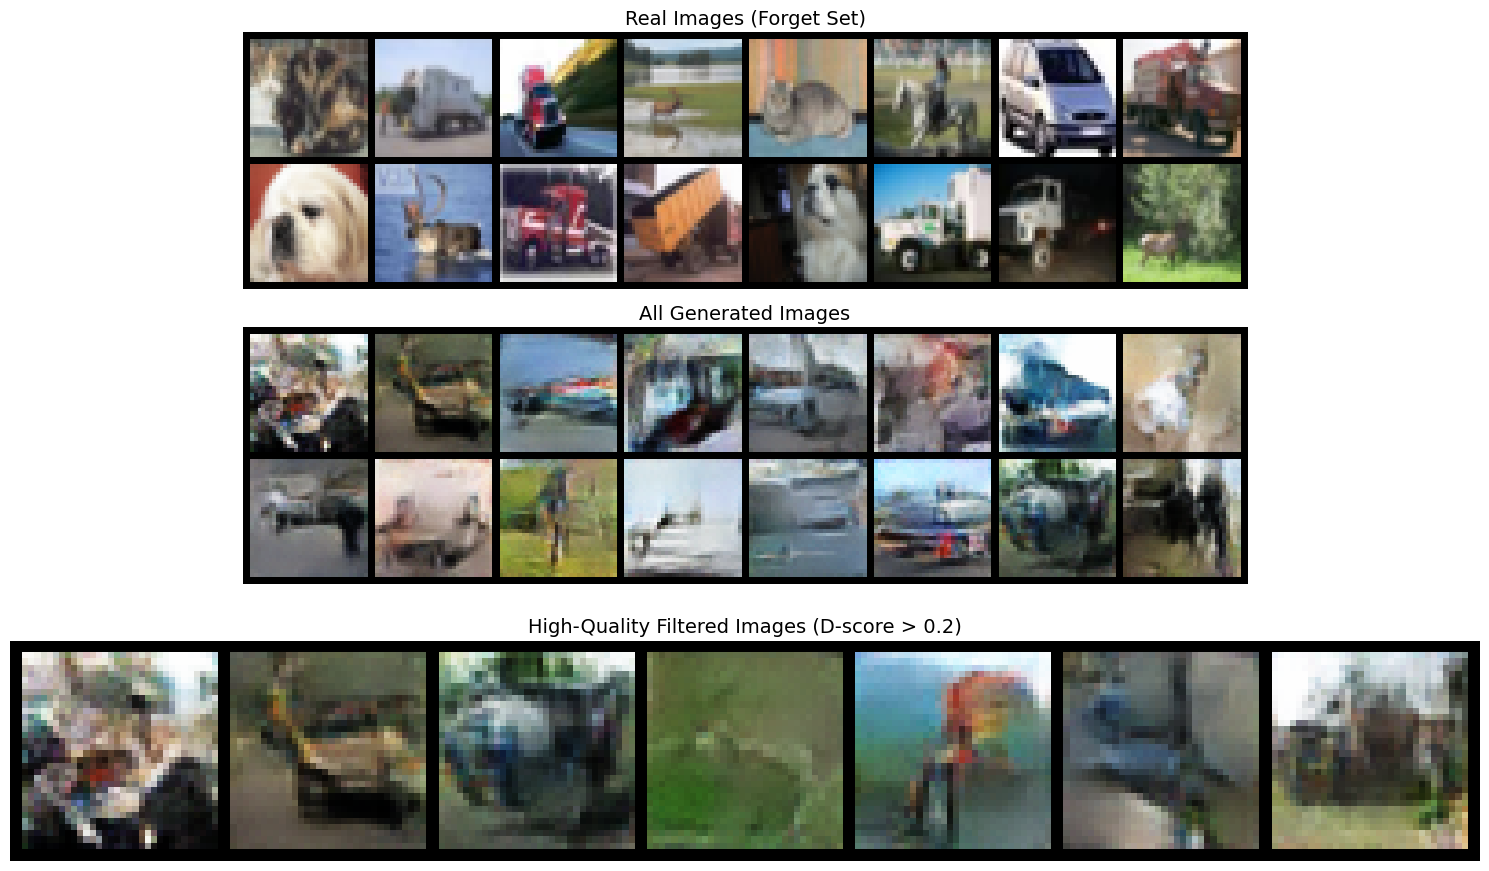

Discriminator Scores - Mean: 0.120, Std: 0.130
High-quality images (>0.2): 7/32
Comparison image saved to: ./real_vs_generated_filtered.png
Generated 1,739 synthetic images in 523.08s

                            RETRAIN MODEL                             


Retrain FL Training:  25%|██▌       | 5/20 [16:08<48:25, 193.70s/it]  

[Retrain] Epoch 5/20 | Loss: 0.0994


Retrain FL Training:  50%|█████     | 10/20 [32:16<32:15, 193.58s/it]

[Retrain] Epoch 10/20 | Loss: 0.0394


Retrain FL Training:  75%|███████▌  | 15/20 [48:27<16:09, 193.91s/it]

[Retrain] Epoch 15/20 | Loss: 0.0222


Retrain FL Training: 100%|██████████| 20/20 [1:04:31<00:00, 193.57s/it]

[Retrain] Epoch 20/20 | Loss: 0.0147



                            FINETUNE MODEL                            


Finetune FL Training:  30%|███       | 3/10 [09:51<23:00, 197.25s/it]

[Finetune] Epoch 3/10 | Loss: 0.0161


Finetune FL Training:  60%|██████    | 6/10 [19:46<13:11, 197.91s/it]

[Finetune] Epoch 6/10 | Loss: 0.0075


Finetune FL Training:  90%|█████████ | 9/10 [29:40<03:18, 198.02s/it]

[Finetune] Epoch 9/10 | Loss: 0.0031


Finetune FL Training: 100%|██████████| 10/10 [32:58<00:00, 197.85s/it]



                MEMBERSHIP INFERENCE ATTACK EVALUATION                

[MIA] Original Model (Before Unlearning):
retain confidence mean: 0.9615431
forget confidence mean: 0.9850794
evalu retain confidence mean: 0.8857018
evalu forget confidence mean: 0.9850794

[MIA] Retrain Model (Gold Standard):
retain confidence mean: 0.9564225
forget confidence mean: 0.882382
evalu retain confidence mean: 0.87898725
evalu forget confidence mean: 0.882382

[MIA] Finetune Model (Our Method):
retain confidence mean: 0.9665891
forget confidence mean: 0.95100147
evalu retain confidence mean: 0.8613256
evalu forget confidence mean: 0.95100147

                         FINAL RESULT SUMMARY                         

Dataset Summary:
   Total Training Data: 45,000
   Forget Set Size: 1,739
   Retain Set Size: 43,261
   Test Set Size: 10,000
   Unseen Data Pool: 5,000
   Generated Synthetic Data: 1,739

Training Time Analysis:
   Original FL:         4056.77s
   Retrain FL:          3871.57s
   Unlearning 

{'original_acc': 0.7738,
 'retrain_acc': 0.7587,
 'finetune_acc': 0.7645,
 'original_time': 4056.770190000534,
 'retrain_time': 3871.5683767795563,
 'unlearning_time': 2501.6201825141907,
 'generation_time': 523.0836226940155,
 'finetune_training_time': 1978.5365598201752,
 'synthetic_count': 1739,
 'mia_scores': {'original': 0.7013475981946489,
  'retrain': 0.4873712063769935,
  'finetune': 0.35339194430381593}}

In [7]:
main()